### Data generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GenerativeModel import ImpactOnOvercrowding

In [2]:
# Generation of synthetic data
np.random.seed(1)
gen = ImpactOnOvercrowding(10000)

data = gen.df

data.head()

maximum : 33.33333333333333
minimum : -22.166666666666668


,Age,Gender,Income,Remote Working Days,Has Car,First-Class,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
0,60,F,84000,4,no,0,3,5,4,1,3,1
1,15,M,50000,3,no,0,2,4,3,3,2,1
2,60,M,109000,3,no,1,5,5,5,3,1,1
3,90,F,84000,4,yes,0,4,5,5,0,1,1
4,15,M,1000,2,no,0,2,4,4,1,3,1


[]

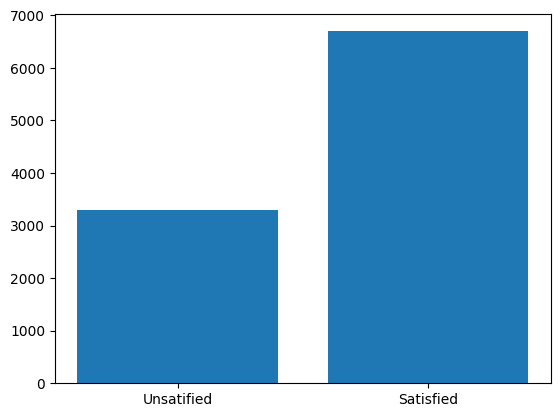

In [3]:
satisf = data['Satisfaction'].value_counts()
plt.bar(["Unsatified", "Satisfied"], [satisf['0'], satisf['1']])
plt.plot()

### Simple Pipeline

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [5]:
numeric_features = [ "Age", "Income", "Remote Working Days",
                    "Price", "Punctuality", "Duration", "Frequency",
                    "Overcrowding"]
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

categorical_features = ["Has Car", "Gender","First-Class"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder())
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

In [7]:
def SimplePipeline(simulator, data_size):
    np.random.seed(1)
    gen = simulator(data_size)
    data = gen.df
    
    X = data.copy().drop(['Satisfaction'], axis=1)
    y = data['Satisfaction']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    def my_pipeline(model, preprocessor):
        clf = Pipeline(
        steps=[("preprocessor", preprocessor),
               ("classifier", model)]
        )
        clf.fit(X_train, y_train)
        return clf.score(X_test, y_test)

    score_random_forest = my_pipeline(RandomForestClassifier(), preprocessor)
    score_logistic = my_pipeline(LogisticRegression(), preprocessor)
    score_perceptron = my_pipeline(Perceptron(), preprocessor)
    score_knn = my_pipeline(KNeighborsClassifier(), preprocessor)
    
    print(f"Simulator = {gen}, Size of data = {data_size}")
    print(f"Accuracy score for Random Forest Classifier: {score_random_forest:.4f}")
    print(f"Accuracy score for Logistic Regression: {score_logistic:.4f}")
    print(f"Accuracy score for Single Layer Perceptron: {score_perceptron:.4f}")
    print(f"Accuracy score for KNeighborsClassifier: {score_knn:.4f}")

    

In [8]:
SimplePipeline(ImpactOnOvercrowding, 10000)

maximum : 33.33333333333333
minimum : -22.166666666666668
Simulator = ImpactOnOvercrowding, Size of data = 10000
Accuracy score for Random Forest Classifier: 0.8585
Accuracy score for Logistic Regression: 0.8494
Accuracy score for Single Layer Perceptron: 0.8448
Accuracy score for KNeighborsClassifier: 0.8388


### Feature selection

#### Why feature selection ?

Because we need to be certain that the results match the simulation. So we do this principally to check if our the results make sense in regard of the simulation. 

In [9]:
from GenerativeModel import NoIncomeDependentSatisfaction

In [10]:
# Generation of synthetic data
np.random.seed(1)
gen = ImpactOnOvercrowding(10000)
data = gen.df
data['Gender'] = data['Gender'].map({'M': 1, 'F': 0})
data['Has Car'] = data['Has Car'].map({'yes': 1, 'no': 0})
data.head()

maximum : 33.33333333333333
minimum : -22.166666666666668


,Age,Gender,Income,Remote Working Days,Has Car,First-Class,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
0,60,0,84000,4,0,0,3,5,4,1,3,1
1,15,1,50000,3,0,0,2,4,3,3,2,1
2,60,1,109000,3,0,1,5,5,5,3,1,1
3,90,0,84000,4,1,0,4,5,5,0,1,1
4,15,1,1000,2,0,0,2,4,4,1,3,1


In [11]:
# Filter method
correlations = data.corr()['Satisfaction'].abs().sort_values(ascending=False)

print('correlation:',correlations)

correlation: Satisfaction           1.000000
Overcrowding           0.523521
Punctuality            0.507186
First-Class            0.240466
Duration               0.088040
Has Car                0.044242
Remote Working Days    0.030754
Frequency              0.024494
Income                 0.018243
Price                  0.007937
Age                    0.004291
Gender                 0.000884
Name: Satisfaction, dtype: float64


In [12]:
# RFE
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Define the model using linear regression
model = LogisticRegression()

# Define RFE with the model and specify the number of features to select
rfe = RFE(model, n_features_to_select=5)

# Separate features and target variable
X = data.drop(columns=['Satisfaction'])
y = data['Satisfaction']

scale = MinMaxScaler()
X_minmax = scale.fit_transform(X)
# Fit RFE to the data
rfe.fit(X_minmax, y)

# Get the ranking of features
feature_ranking = pd.DataFrame({
    'feature': X.columns,
    'rank': rfe.ranking_
}).sort_values(by='rank')

print(feature_ranking)

                feature  rank
5           First-Class     1
6                 Price     1
7           Punctuality     1
8              Duration     1
10         Overcrowding     1
3   Remote Working Days     2
4               Has Car     3
1                Gender     4
9             Frequency     5
2                Income     6
0                   Age     7


In [13]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_minmax, y)

# Get feature importances
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importances)

                feature  importance
10         Overcrowding    0.303314
7           Punctuality    0.255879
3   Remote Working Days    0.074964
9             Frequency    0.064976
8              Duration    0.062072
6                 Price    0.056889
2                Income    0.054680
0                   Age    0.051112
5           First-Class    0.032383
1                Gender    0.023098
4               Has Car    0.020633


In [14]:
# comparing the different models

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

scale = MinMaxScaler()
X_train_minmax = scale.fit_transform(X_train)
X_test_minmax = scale.fit_transform(X_test)

# Model without feature selection
model_all_features = LogisticRegression(max_iter=200)
model_all_features.fit(X_train_minmax, y_train)
predictions_all = model_all_features.predict(X_test_minmax)
accuracy_all = accuracy_score(y_test, predictions_all)
print(f'Accuracy without feature selection: {accuracy_all:.6f}')

# Model with selected features (top 5 from RFE)
selected_features = feature_ranking[feature_ranking['rank'] == 1]['feature']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected_minmax = scale.fit_transform(X_train_selected)
X_test_selected_minmax = scale.fit_transform(X_test_selected)

model_selected_features = LogisticRegression(max_iter=200)
model_selected_features.fit(X_train_selected_minmax, y_train)
predictions_selected = model_selected_features.predict(X_test_selected_minmax)
accuracy_selected = accuracy_score(y_test, predictions_selected)

print(f'Accuracy with feature selection (RFE): {accuracy_selected:.6f}')

# Model with selected features (correleted filter > 0.4)
X_train_selected = X_train.loc[:,["Price", "Overcrowding"]]
X_test_selected = X_test.loc[:,["Price", "Overcrowding"]]

model_selected_features = LogisticRegression(max_iter=200)
model_selected_features.fit(X_train_selected_minmax, y_train)
predictions_selected = model_selected_features.predict(X_test_selected_minmax)
accuracy_selected = accuracy_score(y_test, predictions_selected)

print(f'Accuracy with feature selection (Filter): {accuracy_selected:.6f}')

# Model with selected features (Random Forest)
selected_features = importances[importances['importance'] > 0.1]['feature']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected_minmax = scale.fit_transform(X_train_selected)
X_test_selected_minmax = scale.fit_transform(X_test_selected)

model_selected_features = LogisticRegression(max_iter=200)
model_selected_features.fit(X_train_selected_minmax, y_train)
predictions_selected = model_selected_features.predict(X_test_selected_minmax)
accuracy_selected = accuracy_score(y_test, predictions_selected)

print(f'Accuracy with feature selection (Random Forest): {accuracy_selected:.6f}')

Accuracy without feature selection: 0.845667
Accuracy with feature selection (RFE): 0.846000
Accuracy with feature selection (Filter): 0.846000
Accuracy with feature selection (Random Forest): 0.841333


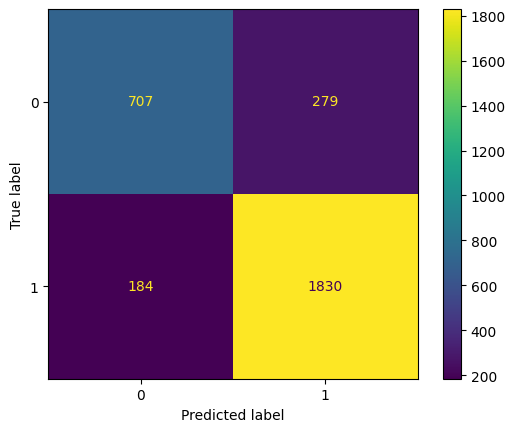

In [15]:
cm = confusion_matrix(y_test, predictions_all, labels=model_all_features.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_all_features.classes_)
disp.plot()
plt.show()

### Key intake:

On remarque que le random forest classifier performe moins bien que les autres lorsque l'on se fie à son classement d'importance.

In [16]:
accuracies = np.zeros(X.shape[1])
for i in range (1, X.shape[1] + 1):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_minmax, y)

    # Get the ranking of features
    feature_ranking = pd.DataFrame({
        'feature': X.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')
    # top i from RFE
    selected_features = feature_ranking[feature_ranking['rank'] == 1]['feature']
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    X_train_selected_minmax = scale.fit_transform(X_train_selected)
    X_test_selected_minmax = scale.fit_transform(X_test_selected)

    model_selected_features = LogisticRegression(max_iter=200)
    model_selected_features.fit(X_train_selected_minmax, y_train)
    predictions_selected = model_selected_features.predict(X_test_selected_minmax)
    accuracies[i - 1] = accuracy_score(y_test, predictions_selected)

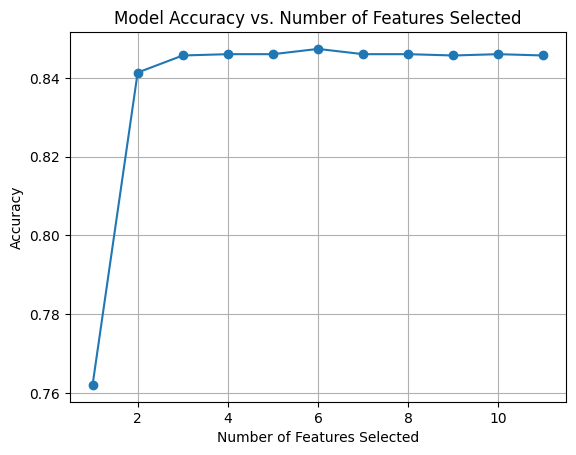

In [17]:
import matplotlib.pyplot as plt
# Plot accuracy vs. number of features
plt.plot(np.arange(1, X.shape[1] + 1), accuracies, marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Number of Features Selected")
plt.grid()
plt.show()

In [18]:
i = np.argmax(accuracies)
print(f"Max accuracy is {accuracies[i]}, with {i + 1} features selected !")

Max accuracy is 0.8473333333333334, with 6 features selected !
